# Imports

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import evaluate
from transformers import AutoTokenizer, GPT2ForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, BitsAndBytesConfig

from sklearn.metrics import f1_score, confusion_matrix, classification_report, balanced_accuracy_score, accuracy_score, precision_score,  recall_score, ConfusionMatrixDisplay

from datasets import Dataset, DatasetDict
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model

import matplotlib.pyplot as plt


c:\Users\Potbottom\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Read dataset and remove duplicate

In [2]:
data = pd.read_csv('ScamDataset.csv', delimiter=',', names=['message', 'label'])

original_shape = data.shape

# Removing duplicate rows
data = data.drop_duplicates()

# Shape after removing duplicates
new_shape = data.shape

original_shape, new_shape

((20670, 2), (15241, 2))

In [3]:
# Shuffle data to avoid any bias
data = data.sample(frac=1).reset_index(drop=True)

In [4]:
data['label'] = data['label'].astype('category')
data['target'] = data['label'].cat.codes
data


,message,label,target
0,Important notice: Your tax refund requires urg...,fraud,0
1,Important notice: Your prize claim requires ur...,fraud,0
2,"重要通知书,尚未领取,查询请按3。 中国领事馆提醒您, 您有一份重要通知书,尚未领取,查询请...",fraud,0
3,to reach you to let you know that your social ...,fraud,0
4,If u dun drive then how i go 2 sch.,normal,1
...,...,...,...
15236,Important notice: Your account verification re...,fraud,0
15237,Is this the same route you cover daily?,normal,1
15238,Important notice: Your tax refund requires urg...,fraud,0
15239,"Madam,regret disturbance.might receive a refer...",normal,1


In [5]:
# Decode
data['label'].cat.categories
category_map = {code: category for code, category in enumerate(data['label'].cat.categories)}
category_map

{0: 'fraud', 1: 'normal'}

In [6]:
train_end_point = int(data.shape[0]*0.6)
val_end_point = int(data.shape[0]*0.8)
df_train = data.iloc[:train_end_point,:]
df_val = data.iloc[train_end_point:val_end_point,:]
df_test = data.iloc[val_end_point:,:]
print(df_train.shape, df_test.shape, df_val.shape)

(9144, 3) (3049, 3) (3048, 3)


In [7]:
# Converting pandas DataFrames into Hugging Face Dataset objects:
dataset_train = Dataset.from_pandas(df_train.drop('label',axis=1))
dataset_val = Dataset.from_pandas(df_val.drop('label',axis=1))
dataset_test = Dataset.from_pandas(df_test.drop('label',axis=1))

In [8]:
# Shuffle the training dataset
dataset_train_shuffled = dataset_train.shuffle(seed=42)  # Using a seed for reproducibility

In [9]:
# Combine them into a single DatasetDict
dataset = DatasetDict({
    'train': dataset_train_shuffled,
    'val': dataset_val,
    'test': dataset_test
})
dataset

DatasetDict({
    train: Dataset({
        features: ['message', 'target'],
        num_rows: 9144
    })
    val: Dataset({
        features: ['message', 'target'],
        num_rows: 3048
    })
    test: Dataset({
        features: ['message', 'target'],
        num_rows: 3049
    })
})

In [10]:
dataset['train']

Dataset({
    features: ['message', 'target'],
    num_rows: 9144
})

In [11]:
df_train.target.value_counts(normalize=True)

target
0    0.54276
1    0.45724
Name: proportion, dtype: float64

In [12]:
class_weights=(1/df_train.target.value_counts(normalize=True).sort_index()).tolist()
class_weights=torch.tensor(class_weights)
class_weights=class_weights/class_weights.sum()
class_weights


tensor([0.4572, 0.5428])

In [13]:
model_name = "openai-community/gpt2"

In [14]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit = True, # enable 4-bit quantization
    bnb_4bit_quant_type = 'nf4', # information theoretically optimal dtype for normally distributed weights
    bnb_4bit_use_double_quant = True, # quantize quantized weights //insert xzibit meme
    bnb_4bit_compute_dtype = torch.bfloat16 # optimized fp format for ML
)

In [15]:
lora_config = LoraConfig(
    r = 16, # the dimension of the low-rank matrices
    lora_alpha = 8, # scaling factor for LoRA activations vs pre-trained weight activations
    target_modules = ['q_proj', 'k_proj', 'v_proj', 'o_proj'],
    lora_dropout = 0.05, # dropout probability of the LoRA layers
    bias = 'none', # wether to train bias weights, set to 'none' for attention layers
    task_type = 'SEQ_CLS'
)

In [16]:
model = GPT2ForSequenceClassification.from_pretrained(model_name,num_labels=2)
model

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at openai-community/gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=2, bias=False)
)

In [17]:
# model = prepare_model_for_kbit_training(model)
# model

In [18]:
# model = get_peft_model(model, lora_config)
# model

In [19]:
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.pad_token = tokenizer.eos_token

In [20]:
model.config.pad_token_id = tokenizer.pad_token_id
model.config.use_cache = False
model.config.pretraining_tp = 1
model.to(torch.device("cuda"))

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=2, bias=False)
)

In [21]:
messages = df_test.message.tolist()
messages

['U so lousy, run already come back then half dead... Hee...',
 'Pro on your account, which is billed on your card attached to your Amazon account. The amount charged in $1,499. We noticed some suspicious activity on your account, so we have put in hold to this transaction. Please press 1 now. And to report, please press 2. Thank you. ',
 'Important notice: Your tax refund requires urgent attention. Act without delay to avoid issues. Ref: 776',
 'Important notice: Your tax refund requires urgent attention. Act without delay to avoid issues. Ref: 6892',
 'Why you Dint come with us.',
 'Aight should I just plan to come up later tonight?',
 'Hmm,  sir this is still a loss for us, but we will agree on this price. Customer satisfaction is our motto.',
 'Tension ah?what machi?any problem?',
 'WHORE YOU ARE UNBELIEVABLE.',
 'Nah im goin 2 the wrks with j wot bout u?',
 'Many more happy returns of the day. I wish you happy birthday.',
 'Important notice: Your tax refund requires urgent attenti

In [22]:
# Convert summaries to a list
messages = df_test.message.tolist()

# Define the batch size
batch_size = 32  # You can adjust this based on your system's memory capacity

# Initialize an empty list to store the model outputs
all_outputs = []

# Process the sentences in batches
for i in range(0, len(messages), batch_size):
    # Get the batch of sentences
    batch_messages = messages[i:i + batch_size]

    # Tokenize the batch
    inputs = tokenizer(batch_messages, return_tensors="pt", padding=True, truncation=True, max_length=512)

    # Move tensors to the device where the model is (e.g., GPU or CPU)
    inputs = {k: v.to('cuda' if torch.cuda.is_available() else 'cpu') for k, v in inputs.items()}

    # Perform inference and store the logits
    with torch.no_grad():
        outputs = model(**inputs)
        all_outputs.append(outputs['logits'])

    print(batch_messages)

['U so lousy, run already come back then half dead... Hee...', 'Pro on your account, which is billed on your card attached to your Amazon account. The amount charged in $1,499. We noticed some suspicious activity on your account, so we have put in hold to this transaction. Please press 1 now. And to report, please press 2. Thank you. ', 'Important notice: Your tax refund requires urgent attention. Act without delay to avoid issues. Ref: 776', 'Important notice: Your tax refund requires urgent attention. Act without delay to avoid issues. Ref: 6892', 'Why you Dint come with us.', 'Aight should I just plan to come up later tonight?', 'Hmm,  sir this is still a loss for us, but we will agree on this price. Customer satisfaction is our motto.', 'Tension ah?what machi?any problem?', 'WHORE YOU ARE UNBELIEVABLE.', 'Nah im goin 2 the wrks with j wot bout u?', 'Many more happy returns of the day. I wish you happy birthday.', 'Important notice: Your tax refund requires urgent attention. Act as 

In [23]:
final_outputs = torch.cat(all_outputs, dim=0)
final_outputs


tensor([[-12.7395,  -3.3177],
        [ -6.2344,  -1.3976],
        [ -9.8173,  -3.7480],
        ...,
        [-10.0091,  -3.8239],
        [ -9.8986,  -3.4107],
        [-13.6498,  -4.2554]], device='cuda:0')

In [24]:

final_outputs.argmax(axis=1)

tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0')

In [25]:
df_test['predictions']=final_outputs.argmax(axis=1).cpu().numpy()
df_test['predictions']

C:\Users\Potbottom\AppData\Local\Temp\ipykernel_20824\1915017267.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions']=final_outputs.argmax(axis=1).cpu().numpy()


12192    1
12193    1
12194    1
12195    1
12196    1
        ..
15236    1
15237    1
15238    1
15239    1
15240    1
Name: predictions, Length: 3049, dtype: int64

In [26]:
df_test['predictions'].value_counts()

predictions
1    3049
Name: count, dtype: int64

In [27]:
df_test['predictions']=df_test['predictions'].apply(lambda l:category_map[l])
df_test['predictions']

C:\Users\Potbottom\AppData\Local\Temp\ipykernel_20824\4293232383.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions']=df_test['predictions'].apply(lambda l:category_map[l])


12192    normal
12193    normal
12194    normal
12195    normal
12196    normal
          ...  
15236    normal
15237    normal
15238    normal
15239    normal
15240    normal
Name: predictions, Length: 3049, dtype: object

In [28]:
def get_performance_metrics(df_test):
  y_test = df_test.label
  y_pred = df_test.predictions

  y_test = y_test.astype('category')
  y_pred = y_pred.astype('category')

  y_test = y_test.cat.codes
  y_pred = y_pred.cat.codes

  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)

  print(f"Accuracy: {accuracy:.4f}")
  print(f"Precision: {precision:.4f}")
  print(f"Recall: {recall:.4f}")
  print(f"F1-Score: {f1:.4f}")

  print("Confusion Matrix:")
  print(confusion_matrix(y_test, y_pred))

  print("\nClassification Report:")
  print(classification_report(y_test, y_pred))

  print("Balanced Accuracy Score:", balanced_accuracy_score(y_test, y_pred))
  print("Accuracy Score:", accuracy_score(y_test, y_pred))

  # Plot confusion matrix
  labels = ['fraud', 'normal']
  cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap=plt.cm.Blues)
  plt.title(f'Confusion Matrix: {model_name}')
  plt.show()
  

# Results before fine tune

Accuracy: 0.5477
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
Confusion Matrix:
[[1670    0]
 [1379    0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.55      1.00      0.71      1670
           1       0.00      0.00      0.00      1379

    accuracy                           0.55      3049
   macro avg       0.27      0.50      0.35      3049
weighted avg       0.30      0.55      0.39      3049

Balanced Accuracy Score: 0.5
Accuracy Score: 0.5477205641193834


c:\Users\Potbottom\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Potbottom\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Potbottom\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average

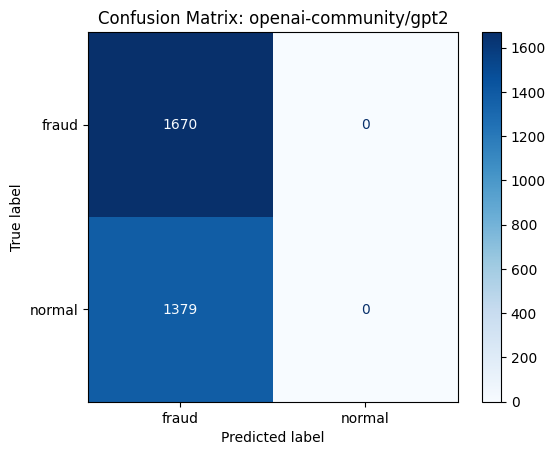

In [29]:
get_performance_metrics(df_test)

# Preprocess and tokenized data

In [30]:
MAX_LEN = 512
col_to_delete = ['message']

def preprocessing_function(examples):
    return tokenizer(examples['message'], truncation=True, max_length=MAX_LEN)

tokenized_datasets = dataset.map(preprocessing_function, batched=True, remove_columns=col_to_delete)
tokenized_datasets = tokenized_datasets.rename_column("target", "label")
tokenized_datasets.set_format("torch")

Map: 100%|██████████| 3049/3049 [00:00<00:00, 49850.64 examples/s]


In [31]:
collate_fn = DataCollatorWithPadding(tokenizer=tokenizer)


In [32]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'balanced_accuracy' : balanced_accuracy_score(predictions, labels),'accuracy':accuracy_score(predictions,labels)}

In [33]:
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        # Ensure label_weights is a tensor
        if class_weights is not None:
            self.class_weights = torch.tensor(class_weights, dtype=torch.float32).to(self.args.device)
        else:
            self.class_weights = None

    def compute_loss(self, model, inputs, return_outputs=False):
        # Extract labels and convert them to long type for cross_entropy
        labels = inputs.pop("labels").long()

        # Forward pass
        outputs = model(**inputs)

        # Extract logits assuming they are directly outputted by the model
        logits = outputs.get('logits')

        # # Compute custom loss with class weights for imbalanced data handling
        if self.class_weights is not None:
            loss = F.cross_entropy(logits, labels, weight=self.class_weights)
        else:
            loss = F.cross_entropy(logits, labels)

        return (loss, outputs) if return_outputs else loss

In [34]:
training_args = TrainingArguments(
    output_dir = 'sentiment_classification',
    learning_rate = 1e-4,
    per_device_train_batch_size = 8,
    per_device_eval_batch_size = 8,
    num_train_epochs = 3,
    weight_decay = 0.01,
    eval_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True
)

In [35]:
trainer = CustomTrainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_datasets['train'],
    eval_dataset = tokenized_datasets['val'],
    tokenizer = tokenizer,
    data_collator = collate_fn,
    compute_metrics = compute_metrics,
    class_weights=class_weights,
)

C:\Users\Potbottom\AppData\Local\Temp\ipykernel_20824\4162890314.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.class_weights = torch.tensor(class_weights, dtype=torch.float32).to(self.args.device)


# Train model

In [36]:
train_result = trainer.train()

 15%|█▍        | 501/3429 [00:38<04:08, 11.78it/s]

{'loss': 0.1499, 'grad_norm': 6.644211769104004, 'learning_rate': 8.541848935549723e-05, 'epoch': 0.44}


 29%|██▉       | 1001/3429 [01:15<03:10, 12.71it/s]

{'loss': 0.0656, 'grad_norm': 0.0695246234536171, 'learning_rate': 7.083697871099446e-05, 'epoch': 0.87}


                                                   
 33%|███▎      | 1143/3429 [01:33<03:14, 11.74it/s]

{'eval_loss': 0.08169936388731003, 'eval_balanced_accuracy': 0.9890630765239137, 'eval_accuracy': 0.9898293963254593, 'eval_runtime': 5.9353, 'eval_samples_per_second': 513.542, 'eval_steps_per_second': 64.193, 'epoch': 1.0}


 44%|████▍     | 1501/3429 [02:00<02:29, 12.92it/s]

{'loss': 0.0317, 'grad_norm': 0.0026191158685833216, 'learning_rate': 5.625546806649169e-05, 'epoch': 1.31}


 58%|█████▊    | 2003/3429 [02:37<01:42, 13.91it/s]

{'loss': 0.0503, 'grad_norm': 0.02285167947411537, 'learning_rate': 4.167395742198892e-05, 'epoch': 1.75}


                                                   
 67%|██████▋   | 2286/3429 [03:06<01:33, 12.27it/s]

{'eval_loss': 0.05363361909985542, 'eval_balanced_accuracy': 0.9924838299398855, 'eval_accuracy': 0.9931102362204725, 'eval_runtime': 6.2706, 'eval_samples_per_second': 486.075, 'eval_steps_per_second': 60.759, 'epoch': 2.0}


 73%|███████▎  | 2503/3429 [03:24<01:04, 14.41it/s]

{'loss': 0.0187, 'grad_norm': 0.001329088700003922, 'learning_rate': 2.7092446777486146e-05, 'epoch': 2.19}


 88%|████████▊ | 3001/3429 [04:02<00:31, 13.59it/s]

{'loss': 0.0162, 'grad_norm': 0.024547528475522995, 'learning_rate': 1.2510936132983377e-05, 'epoch': 2.62}


                                                   
100%|██████████| 3429/3429 [04:41<00:00, 12.67it/s]

{'eval_loss': 0.0440131314098835, 'eval_balanced_accuracy': 0.9929016991030337, 'eval_accuracy': 0.9934383202099738, 'eval_runtime': 6.0651, 'eval_samples_per_second': 502.544, 'eval_steps_per_second': 62.818, 'epoch': 3.0}


100%|██████████| 3429/3429 [04:43<00:00, 12.11it/s]

{'train_runtime': 283.0791, 'train_samples_per_second': 96.906, 'train_steps_per_second': 12.113, 'train_loss': 0.050207845043183486, 'epoch': 3.0}


In [37]:
def make_predictions(model,df_test):


  # Convert summaries to a list
  messages = df_test.message.tolist()

  # Define the batch size
  batch_size = 32  # You can adjust this based on your system's memory capacity

  # Initialize an empty list to store the model outputs
  all_outputs = []

  # Process the sentences in batches
  for i in range(0, len(messages), batch_size):
      # Get the batch of sentences
      batch_messages = messages[i:i + batch_size]

      # Tokenize the batch
      inputs = tokenizer(batch_messages, return_tensors="pt", padding=True, truncation=True, max_length=512)

      # Move tensors to the device where the model is (e.g., GPU or CPU)
      inputs = {k: v.to('cuda' if torch.cuda.is_available() else 'cpu') for k, v in inputs.items()}

      # Perform inference and store the logits
      with torch.no_grad():
          outputs = model(**inputs)
          all_outputs.append(outputs['logits'])
      
      print(batch_messages)

  final_outputs = torch.cat(all_outputs, dim=0)
  df_test['predictions']=final_outputs.argmax(axis=1).cpu().numpy()
  df_test['predictions']=df_test['predictions'].apply(lambda l:category_map[l])


make_predictions(model,df_test)

['U so lousy, run already come back then half dead... Hee...', 'Pro on your account, which is billed on your card attached to your Amazon account. The amount charged in $1,499. We noticed some suspicious activity on your account, so we have put in hold to this transaction. Please press 1 now. And to report, please press 2. Thank you. ', 'Important notice: Your tax refund requires urgent attention. Act without delay to avoid issues. Ref: 776', 'Important notice: Your tax refund requires urgent attention. Act without delay to avoid issues. Ref: 6892', 'Why you Dint come with us.', 'Aight should I just plan to come up later tonight?', 'Hmm,  sir this is still a loss for us, but we will agree on this price. Customer satisfaction is our motto.', 'Tension ah?what machi?any problem?', 'WHORE YOU ARE UNBELIEVABLE.', 'Nah im goin 2 the wrks with j wot bout u?', 'Many more happy returns of the day. I wish you happy birthday.', 'Important notice: Your tax refund requires urgent attention. Act as 

C:\Users\Potbottom\AppData\Local\Temp\ipykernel_20824\3895869390.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions']=final_outputs.argmax(axis=1).cpu().numpy()
C:\Users\Potbottom\AppData\Local\Temp\ipykernel_20824\3895869390.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions']=df_test['predictions'].apply(lambda l:category_map[l])


Accuracy: 0.9951
Precision: 0.9942
Recall: 0.9949
F1-Score: 0.9946
Confusion Matrix:
[[1662    8]
 [   7 1372]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1670
           1       0.99      0.99      0.99      1379

    accuracy                           1.00      3049
   macro avg       1.00      1.00      1.00      3049
weighted avg       1.00      1.00      1.00      3049

Balanced Accuracy Score: 0.9950667193531718
Accuracy Score: 0.9950803542144966


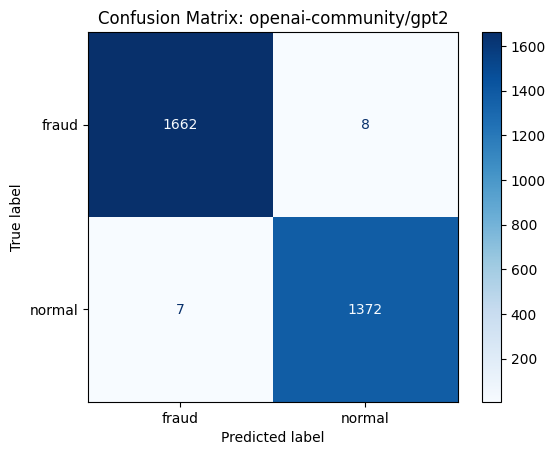

In [38]:
get_performance_metrics(df_test)

In [39]:
metrics = train_result.metrics
max_train_samples = len(dataset_train)
metrics["train_samples"] = min(max_train_samples, len(dataset_train))
trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =        3.0
  total_flos               =   738340GF
  train_loss               =     0.0502
  train_runtime            = 0:04:43.07
  train_samples            =       9144
  train_samples_per_second =     96.906
  train_steps_per_second   =     12.113
